<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/main/scikit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#imports
import pandas as pd
import os
import random
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
#Get the filepaths to the CSVs we're interested in

root = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/'
files = os.listdir(root)
#spatial_files = [s for s in spatial_files if date_fly in s and '.h5' in s]
filepaths = [root + s for s in files]
filepaths

['/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_1_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_2_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_3_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_4_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_allStacks_mc_mix1_syt_rawExtracts/1 Frame/210815_0_5_mc_mix1_syt_1frameWindow_rawExtract.csv',
 '/content/drive/MyDrive/

In [4]:
#pull in the single framed features
df = pd.concat(map(pd.read_csv, filepaths), ignore_index=True)

#drop duplicates and sample just 5000 obs for speed, need more observations for actually training
df = df.drop(columns = ['Unnamed: 0']).drop_duplicates()
df.head()

,roi_ID,area,center_of_mass_row,center_of_mass_column,resp,stim1,label,frame_number
0,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.244535,-0.700161,tm2,0
1,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.398458,-0.700161,tm2,1
2,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.619290,-0.405675,tm2,2
3,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.627615,0.772268,tm2,3
4,210815_0_1_0_mc_mix1_syt_,98,33.969388,76.22449,0.611509,0.772268,tm2,4


In [5]:
df['label'].value_counts()

tm2    363853
tm4    207916
t5     103958
tm9     51979
tm1     51979
Name: label, dtype: int64

In [6]:
df['resp_scaled'] = df['resp'] /df['resp'].abs().max()
df['sq_difference'] = (df['resp_scaled']-df['stim1'])**2
df['product'] = df['resp_scaled']*df['stim1']
#df = df.loc[df['sq_difference'] >.5]

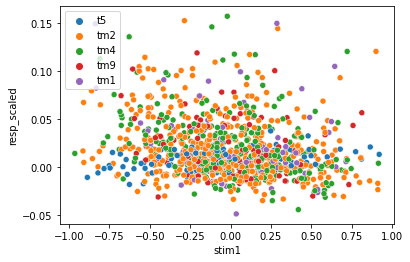

In [7]:
#playing with visualizing the data, no separation with just this feature
df_sample = df.sample(1000)
sns.scatterplot(x=df_sample['stim1'], y=df_sample['resp_scaled'], hue=df_sample['label'])
plt.legend()

In [8]:
#train test split by roi_ID so that no single roi is included in the training and testing data
#Right now the split is random

rois = df.drop_duplicates('roi_ID')[['roi_ID', 'label']]

X = np.array(rois['roi_ID'])
y = np.array(rois['label'])


#split into training and testing - returns the indexes
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)

#These are lists of the rois to be included in each split, not the actual data
X_train_rois, X_test_rois = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]


TRAIN: [130  23  17  74  32  97 105  43   5  46  92  65  29  13  71  39  19  16
   7  62 162  91  99 157  63  54  56  49 131 144  87 103  15  12  94 129
  21 124  25 116 154  80 143  86 119  55 155 120  47 163   4  96 127 101
 156 115 134 102  98 123  28  70 159   3 110  59  78  45 108  33 150  22
  81  20 161  36  83 137  58 152 148  44] TEST: [ 64  89 151  67 139  52 158 164 121  51  88  37 141   2  75 146 117 126
   1  60  84  79  68  14  40  10 133  66  11 104 136 113  31  82 147  57
  30 107  93 111  24 149 153   9  61 125   6  73 140  26 100 142 135 109
  95 138  34  85  69   8  77 118  42  90  18 112 106 145  41 122  27  53
 160  38  50 128 132   0  72 114  35  76  48]


In [9]:
#use the roi_id's as indexes to split train and test from our full df
X_train = df.query('roi_ID in @X_train_rois')[['sq_difference', 'product']]
y_train = df.query('roi_ID in @X_train_rois')['label'] 

X_test = df.query('roi_ID in @X_test_rois')[['sq_difference','product']]
y_test = df.query('roi_ID in @X_test_rois')['label']     

#resample the training set to balance the classes (upsampling the underrepresented classes)
from imblearn.over_sampling import SMOTE
smote_nc = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

In [10]:
#Scale based on X_train to avoid data leakage
scaler = StandardScaler() 
scaler.fit(X_train_resampled)
X_train_resampled = scaler.transform(X_train_resampled)  
# apply same transformation to test data
X_test = scaler.transform(X_test)

# try a model and score it based on the most predicted class for each roi

In [11]:
#knn
model = KNeighborsClassifier(100)
model.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(n_neighbors=100)

In [12]:
#return the predicted classes and probabilities
preds_prob = model.predict_proba(X_test)
preds = model.predict(X_test)
print(model.classes_)
preds_prob

['t5' 'tm1' 'tm2' 'tm4' 'tm9']


array([[0.11, 0.13, 0.2 , 0.25, 0.31],
       [0.05, 0.09, 0.24, 0.29, 0.33],
       [0.09, 0.06, 0.31, 0.23, 0.31],
       ...,
       [0.01, 0.21, 0.24, 0.32, 0.22],
       [0.02, 0.2 , 0.12, 0.36, 0.3 ],
       [0.06, 0.28, 0.27, 0.27, 0.12]])

0.19213890626246716


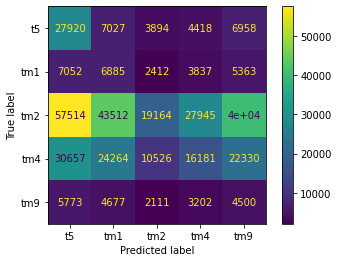

In [ ]:
print(model.score(X_test, y_test)) #accuracy based on frame-level predictions
ConfusionMatrixDisplay.from_predictions(y_test, preds)

In [13]:
#add the classes and probabilities back to the df of test set records
test_df = df.query('roi_ID in @X_test_rois')
test_df[['t5', 'tm1', 'tm2', 'tm4', 'tm9']] = preds_prob
test_df['pred'] = preds

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
#groupby the roi_id and predicted class to see the number of times each cell was predicted which class
#right now it classifies everything as tm1
max_preds = test_df.groupby(['roi_ID', 'pred']).count() \
    .reset_index() \
    .sort_values(['roi_ID', 'label'], ascending = False) \
    .drop_duplicates('roi_ID', keep='first') \
    [['roi_ID', 'pred']] \
    .rename(columns = {'pred': 'most_predicted_class'}) \
    .set_index('roi_ID')


In [15]:
max_preds.head()

,most_predicted_class
roi_ID,
210815_0_9_8_mc_mix1_syt_,t5
210815_0_9_6_mc_mix1_syt_,t5
210815_0_9_5_mc_mix1_syt_,t5
210815_0_9_2_mc_mix1_syt_,t5
210815_0_9_1_mc_mix1_syt_,t5


In [16]:
#get the actual labels for the rois in the test set
test_labels = test_df[['roi_ID', 'label']].drop_duplicates('roi_ID').set_index('roi_ID')
test_labels.head()

,label
roi_ID,
210815_0_1_0_mc_mix1_syt_,tm2
210815_0_1_1_mc_mix1_syt_,tm2
210815_0_1_2_mc_mix1_syt_,tm4
210815_0_1_6_mc_mix1_syt_,tm1
210815_0_1_8_mc_mix1_syt_,tm4


In [17]:
#join the actual labels to the most predicted class labels
max_preds = max_preds.join(test_labels)
max_preds.head()

,most_predicted_class,label
roi_ID,,
210815_0_9_8_mc_mix1_syt_,t5,tm4
210815_0_9_6_mc_mix1_syt_,t5,tm1
210815_0_9_5_mc_mix1_syt_,t5,tm9
210815_0_9_2_mc_mix1_syt_,t5,tm4
210815_0_9_1_mc_mix1_syt_,t5,tm2


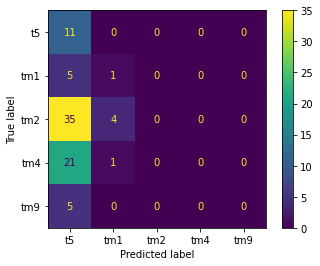

In [18]:
#show the confusion matrix for the test set rois
ConfusionMatrixDisplay.from_predictions(max_preds['label'], max_preds['most_predicted_class'])

In [ ]:
# # Code source: Gaël Varoquaux
# #              Andreas Müller
# # Modified for documentation by Jaques Grobler
# # License: BSD 3 clause



# names = [
#     "Nearest Neighbors",
#     "Linear SVM",
#     "RBF SVM",
#     "Gaussian Process",
#     "Decision Tree",
#     "Random Forest",
#     "Neural Net",
#     "AdaBoost",
#     "Naive Bayes",
#     "QDA",
# ]

# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     #GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=3),
#     RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=.01, max_iter=1000),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]


# # # preprocess dataset, split into training and test part
# # X_train, X_test, y_train, y_test = train_test_split(
# #     X_resampled, y_resampled, test_size=0.3, random_state=101
# # )

# #Scale based on X_train to avoid data leakage
# scaler = StandardScaler() 
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)  
# # apply same transformation to test data
# X_test = scaler.transform(X_test)


# # iterate over classifiers
# for name, clf in zip(names, classifiers):
#     clf.fit(X_train, y_train)
#     score = clf.score(X_test, y_test)
#     print(f'{name}: score: {score}')

#     preds = clf.predict(X_test)
#     ConfusionMatrixDisplay.from_predictions(y_test, preds)
#     plt.show()
